# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

**Notebook generated with the assistance of AI. Please be cautious when interpreting the code or results, and review outputs before using them in your own work.**

## Overview

This notebook walks you through key steps for exploring the NWB dataset from [Dandiset 001361](https://dandiarchive.org/dandiset/001361/0.250406.0045), titled *A flexible hippocampal population code for experience relative to reward*.

The dataset contains two-photon calcium imaging and behavioral data from mouse hippocampal area CA1, recorded while subjects navigated a virtual reality environment with changing reward locations. Data are organized as NWB files and include both raw and processed imaging, as well as detailed behavioral time series.

**What you'll find in this notebook:**
- How to list NWB files associated with this dandiset.
- How to stream and inspect the structure of an NWB file.
- How to extract and visualize neural fluorescence traces for an ROI.
- How to extract and plot a behavioral variable (running speed).
- How to visualize the spatial locations and masks of ROIs from the imaging session.

The steps are designed for researchers interested in getting started with their own exploration and reanalysis.

## Required Packages

This notebook assumes you have the following packages already installed:
- dandi
- pynwb
- remfile
- h5py
- numpy
- matplotlib

(Installation instructions are not provided here; see official docs for details.)

## Listing NWB Files with the DANDI API

First, let's identify a few representative NWB files in this Dandiset using the DANDI API.

In [1]:
from dandi.dandiapi import DandiAPIClient

# Connect to the specific dandiset and version
dandiset_id = "001361"
dandiset_version = "0.250406.0045"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 5 NWB files in the dandiset
nwb_files = []
for asset in dandiset.get_assets_by_glob("*.nwb"):
    nwb_files.append(asset.path)
    if len(nwb_files) >= 5:
        break

print("Sample NWB files in dandiset 001361:")
for f in nwb_files:
    print(f)

Sample NWB files in dandiset 001361:
sub-m11/sub-m11_ses-05_behavior+ophys.nwb
sub-m11/sub-m11_ses-04_behavior+ophys.nwb
sub-m11/sub-m11_ses-07_behavior+ophys.nwb
sub-m11/sub-m11_ses-06_behavior+ophys.nwb
sub-m11/sub-m11_ses-08_behavior+ophys.nwb


## Loading and Examining the Structure of an NWB File

We'll stream one NWB file (`sub-m11/sub-m11_ses-05_behavior+ophys.nwb`) from DANDI and inspect its top-level contents.

*Note: NWB files can be very large; streaming avoids full downloads but may still be slow for some operations.*

In [2]:
import pynwb
import h5py
import remfile

# Select a single NWB file to explore
nwb_path = "sub-m11/sub-m11_ses-05_behavior+ophys.nwb"
asset = next(dandiset.get_assets_by_glob(nwb_path))

# Stream the file using remfile and h5py
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)

# Load NWB file with pynwb
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Print high-level info
print("Identifier:", nwb.identifier)
print("Session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("Subject:", nwb.subject.subject_id, "Species:", nwb.subject.species, "Sex:", nwb.subject.sex)
print("Acquisition keys:", list(nwb.acquisition.keys()))
print("Processing modules:", list(nwb.processing.keys()))
print("Imaging planes:", list(nwb.imaging_planes.keys()))
print("Devices:", list(nwb.devices.keys()))

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Identifier: /data/InVivoDA/GCAMP11/25_02_2023/Env1_LocationA_to_C
Session description: processed suite2p data
Session start time: 2023-02-25 00:00:00-08:00
Subject: m11 Species: Mus musculus Sex: M
Acquisition keys: ['TwoPhotonSeries']
Processing modules: ['behavior', 'ophys']
Imaging planes: ['ImagingPlane']
Devices: ['Microscope']


## Visualizing a Neural Fluorescence Trace (ROI 0)

Let's extract and plot the fluorescence signal for the first ROI (ROI 0) over the first 1000 imaging timepoints. This data is found in the `Fluorescence` interface of the `ophys` processing module.

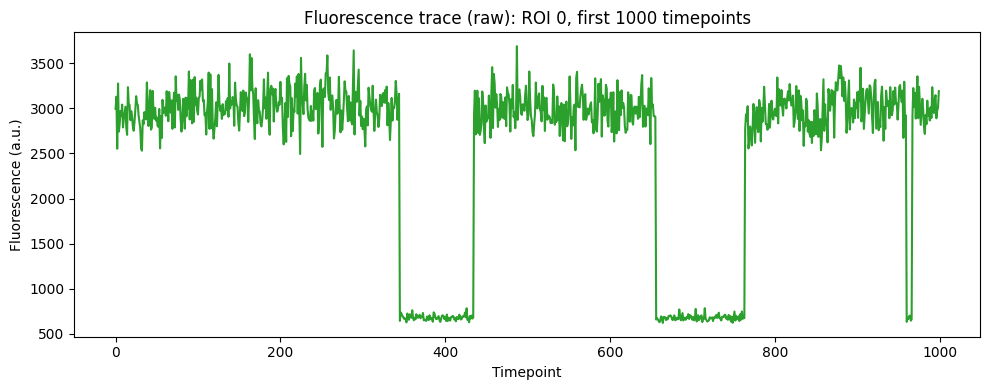

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Access the ophys/Fluorescence data interface
flu = nwb.processing['ophys'].data_interfaces['Fluorescence']
rroi = flu.roi_response_series['plane0']  # data shape: (time, n_rois)

# Extract signal for the first ROI (ROI 0)
fluo_trace = rroi.data[:1000, 0].astype(np.float32)  # first 1000 timepoints

plt.figure(figsize=(10, 4))
plt.plot(fluo_trace, color='tab:green')
plt.title('Fluorescence trace (raw): ROI 0, first 1000 timepoints')
plt.xlabel('Timepoint')
plt.ylabel('Fluorescence (a.u.)')
plt.tight_layout()
plt.show()

## Accessing and Visualizing a Behavioral Variable (Running Speed)

Now, let's extract and plot the running speed for the same time period using the `behavior` processing module.

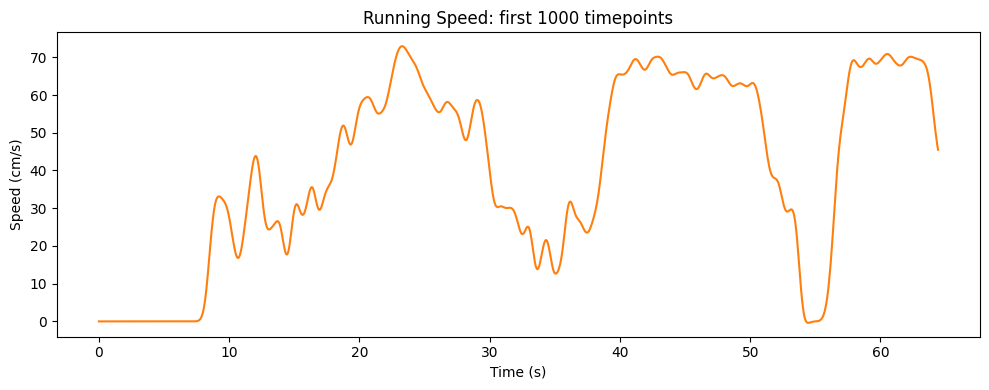

In [4]:
# Access the behavioral time series (speed)
timeseries = nwb.processing['behavior'].data_interfaces['BehavioralTimeSeries'].time_series
speed = timeseries['speed']

speed_data = speed.data[:1000].astype(np.float32)
speed_times = speed.timestamps[:1000]

plt.figure(figsize=(10, 4))
plt.plot(speed_times, speed_data, color='tab:orange')
plt.title('Running Speed: first 1000 timepoints')
plt.xlabel('Time (s)')
plt.ylabel('Speed (cm/s)')
plt.tight_layout()
plt.show()

## Visualizing ROI Spatial Masks (Contours & Centroids)

This section visualizes the pixel masks (spatial contours) and centroids of the first 10 ROIs as identified by Suite2p segmentation, providing an overview of their locations within the imaging field.

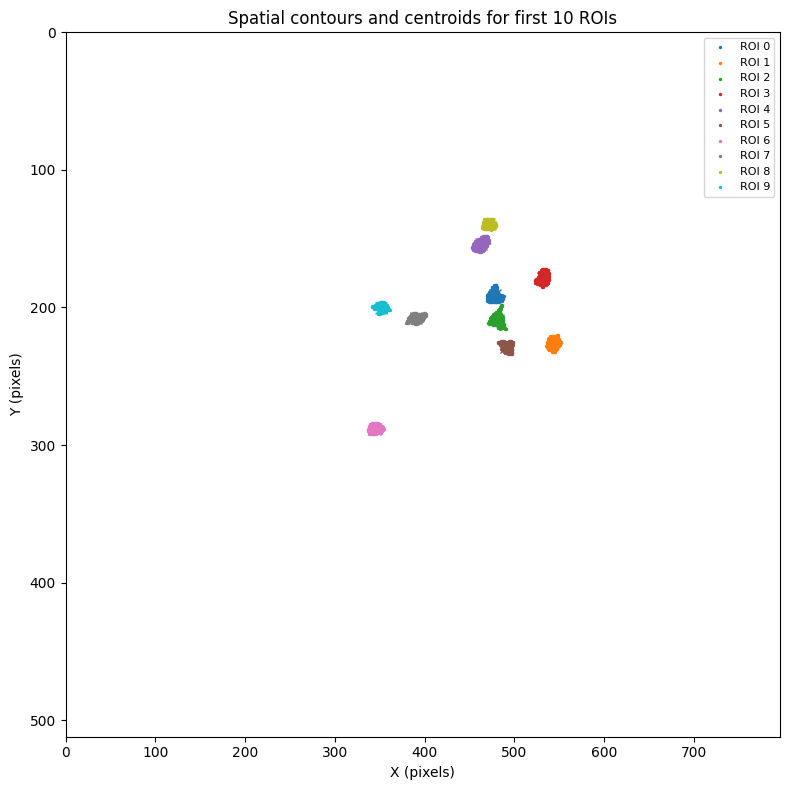

In [5]:
# Access PlaneSegmentation from ophys/ImageSegmentation
plane_seg = nwb.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation']
frame_shape = nwb.acquisition['TwoPhotonSeries'].dimension[:]

plt.figure(figsize=(8, 8))
for i in range(10):
    pmask = plane_seg['pixel_mask'][i]
    yx = np.array([[p[0], p[1]] for p in pmask])  # (y, x) for each pixel in mask
    plt.scatter(yx[:, 1], yx[:, 0], s=2, label=f'ROI {i}')
    # Plot centroid for each ROI
    centroid = yx.mean(axis=0)
    plt.plot(centroid[1], centroid[0], 'x', markersize=8)

plt.title('Spatial contours and centroids for first 10 ROIs')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.xlim(0, frame_shape[1])
plt.ylim(0, frame_shape[0])
plt.gca().invert_yaxis()  # Conventional for image coordinates
plt.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated how to:

- Connect to a dandiset and list NWB files using the DANDI API
- Stream and inspect the structure of an NWB file without downloading
- Extract and plot neural and behavioral signals
- Visualize the spatial arrangement of ROIs

These basics should help you get started exploring Dandiset 001361 and adapting the workflow for your own analyses. For further exploration, see the [DANDI archive](https://dandiarchive.org/dandiset/001361/0.250406.0045) or associated [analysis code](https://github.com/GiocomoLab/Sosa_et_al_2024).